# UNI/ETH Strategy Simulation

In this notebook we will be studying the potential performance of Gamma Strategies' **Strategy 2**, as implemented in ```AutoRegressiveStrategy.py``` on the UNI/ETH pool. This is an interesting pool as these are both "volatile" pairs with some positive correlation, which can help mitigate the impermanent loss relative to a pool that contains a volatile token and a stablecoin.

The strategy uses the AR(1)-GARCH(1,1) model to derive the limits of the liquidity provision ranges, as well as its center based on daily return data. The returns are measured with the change in the relative price of ETH in terms of UNI, which is how the pool is denominated and are the ranges we need to set. It is for this reason that we also need to pull one of the token prices in terms of USD, in order to convert these figures into USD for evaluating the performance of the strategy.

As before, the underlying model is a simple AR(1)-GARCH(1,1) model, which estimates the recent expected return and the volatility of the price based on recent observations.

Suppose that the price at time $t$ of the UNI-WETH 0.3% pool is $q_t$, then the price in USDC terms would be $p_t = 1/q_t$. The return is defined as $r_t = p_t / p_{t-1} - 1$, and this is the time series we model:

$$ r_t = c + \rho r_{t-1} + \sigma_t \varepsilon_t$$
$$ \sigma_t^2 = \omega + \alpha \varepsilon_{t-1} + \beta\sigma_{t-1}^2$$

For the strategy, we estimate the model only with the data the was available at that time, therefore making the simulations more realistic. Note that automatically setting bin width is part of the well-known Bollinger Bands strategy. Imposing a consistent statistical model gives more structure to the optimization problem, as well as allowing for forecasting and simulation more easily.

In [3]:
import pandas as pd
import numpy as np
import GetPoolData, AutoRegressiveStrategy, ActiveStrategyFramework
import itertools
import arch
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
import scipy
import os


# Create config.py in this directory and enter your own Bitquery API Token
import config
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = config.GOOGLE_SERVICE_AUTH_JSON

#################
#
# Download data
#
################

# Relevant pool variables - need UNI/ETH and ETH/USDC pools to be able to model USD values 
uni_pool_address      = '0x1d42064fc4beb5f8aaf85f4617ae8b3b5b8bd801'  
eth_usdc_pooL_address = '0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8'
decimals_0            = 18
decimals_1            = 18
decimals_0_eth_usdc   = 6
decimals_1_eth_usdc   = 18

# Download all available data
price_data_begin   = '2024-08-01'
price_data_end     = '2025-05-01'
file_name          = 'eth_uni'
file_name_usd_1    = 'usdc_eth'

uni_pool_data      = GetPoolData.get_pool_data_bigquery(uni_pool_address,price_data_begin,price_data_end,decimals_0,decimals_1)
eth_usdc_pool_data = GetPoolData.get_pool_data_bigquery(eth_usdc_pooL_address,price_data_begin,price_data_end,decimals_0_eth_usdc,decimals_1_eth_usdc)


In [2]:
# Create token_0_usd_data (UNI/USD)
# Debug data sources
print(f"uni_pool_data shape: {uni_pool_data.shape}")
print(f"uni_pool_data timestamp range: {uni_pool_data.index.min()} to {uni_pool_data.index.max()}")
print(f"eth_usdc_pool_data shape: {eth_usdc_pool_data.shape}")
print(f"eth_usdc_pool_data timestamp range: {eth_usdc_pool_data.index.min()} to {eth_usdc_pool_data.index.max()}")

# ETH/USDC price in quotePrice is expressed as WETH/USDC
eth_usdc_pool_data['quotePrice_eth'] = eth_usdc_pool_data['quotePrice']

# Convert indices to datetime64[ns, UTC]
uni_pool_data.index = uni_pool_data.index.astype('datetime64[ns, UTC]')
eth_usdc_pool_data.index = eth_usdc_pool_data.index.astype('datetime64[ns, UTC]')
print(f"uni_pool_data index dtype after conversion: {uni_pool_data.index.dtype}")
print(f"eth_usdc_pool_data index dtype after conversion: {eth_usdc_pool_data.index.dtype}")

# Aggregate uni_pool_data to minute frequency
agg_data = ActiveStrategyFramework.aggregate_price_data(uni_pool_data, 'm')
print(f"agg_data shape: {agg_data.shape}")
print(f"agg_data timestamp range: {agg_data.index.min()} to {agg_data.index.max()}")

# Perform merge_asof
token_0_usd_data = pd.merge_asof(
    agg_data,
    eth_usdc_pool_data[['quotePrice_eth']],
    left_index=True,
    right_index=True,
    direction='backward'
).ffill()

# Compute UNI/USD: quotePrice_eth (WETH/USDC) / quotePrice (WETH/UNI) = UNI/USDC
token_0_usd_data['quotePrice'] = token_0_usd_data['quotePrice_eth'] / token_0_usd_data['quotePrice'].replace(0, np.nan)
token_0_usd_data['quotePrice'] = token_0_usd_data['quotePrice'].ffill()

print(f"token_0_usd_data shape: {token_0_usd_data.shape}")
print(f"token_0_usd_data timestamp range: {token_0_usd_data.index.min()} to {token_0_usd_data.index.max()}")
print(f"token_0_usd_data quotePrice NaN count: {token_0_usd_data['quotePrice'].isna().sum()}")
print(f"token_0_usd_data head:\n{token_0_usd_data.head()}")

uni_pool_data shape: (112756, 22)
uni_pool_data timestamp range: 2024-08-01 00:08:35+00:00 to 2025-05-31 23:54:11+00:00
eth_usdc_pool_data shape: (138741, 22)
eth_usdc_pool_data timestamp range: 2024-08-01 00:29:47+00:00 to 2025-05-31 23:59:11+00:00
uni_pool_data index dtype after conversion: datetime64[ns, UTC]
eth_usdc_pool_data index dtype after conversion: datetime64[ns, UTC]
Input data index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Input data index dtype: datetime64[ns, UTC]
data_floored_min index dtype after conversion: datetime64[ns, UTC]
data_floored_min index type after floor: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
data_floored_min index dtype after floor: datetime64[ns, UTC]
price_range index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
price_range index dtype: datetime64[ns, UTC]
new_data index type before resample: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
new_data index dtype before resample: datetime64[ns, UTC]


In [3]:
token_0_usd_data.head()

,block_timestamp,block_number,transaction_hash,log_index,contract_address,sender,recipient,amount0,amount1,sqrtPriceX96,...,block_date,tick_swap,amount0_adj,amount1_adj,virtual_liquidity,virtual_liquidity_adj,token_in,traded_in,price_return,quotePrice_eth
2024-08-01 00:08:00+00:00,2024-08-01 00:08:35+00:00,20430015,0xd2b7f276d20195eed21d343be5064633095abda9fe7a...,124,0x1d42064fc4beb5f8aaf85f4617ae8b3b5b8bd801,0x51c72848c68a965f66fa7a88855f9f7784502a7f,0x51c72848c68a965f66fa7a88855f9f7784502a7f,1.573053e+21,-3.488544e+18,3736111660804259442462847748,...,2024-08-01 00:08:35+00:00,-61089,1573.052867,-3.488544,2.565769e+23,256576.914907,token1,3.488544,NaN,NaN
2024-08-01 00:09:00+00:00,2024-08-01 00:08:35+00:00,20430015,0xd2b7f276d20195eed21d343be5064633095abda9fe7a...,124,0x1d42064fc4beb5f8aaf85f4617ae8b3b5b8bd801,0x51c72848c68a965f66fa7a88855f9f7784502a7f,0x51c72848c68a965f66fa7a88855f9f7784502a7f,1.573053e+21,-3.488544e+18,3736111660804259442462847748,...,2024-08-01 00:08:35+00:00,-61089,1573.052867,-3.488544,2.565769e+23,256576.914907,token1,3.488544,0.000000,NaN
2024-08-01 00:10:00+00:00,2024-08-01 00:08:35+00:00,20430015,0xd2b7f276d20195eed21d343be5064633095abda9fe7a...,124,0x1d42064fc4beb5f8aaf85f4617ae8b3b5b8bd801,0x51c72848c68a965f66fa7a88855f9f7784502a7f,0x51c72848c68a965f66fa7a88855f9f7784502a7f,1.573053e+21,-3.488544e+18,3736111660804259442462847748,...,2024-08-01 00:08:35+00:00,-61089,1573.052867,-3.488544,2.565769e+23,256576.914907,token1,3.488544,0.000000,NaN
2024-08-01 00:11:00+00:00,2024-08-01 00:08:35+00:00,20430015,0xd2b7f276d20195eed21d343be5064633095abda9fe7a...,124,0x1d42064fc4beb5f8aaf85f4617ae8b3b5b8bd801,0x51c72848c68a965f66fa7a88855f9f7784502a7f,0x51c72848c68a965f66fa7a88855f9f7784502a7f,1.573053e+21,-3.488544e+18,3736111660804259442462847748,...,2024-08-01 00:08:35+00:00,-61089,1573.052867,-3.488544,2.565769e+23,256576.914907,token1,3.488544,0.000000,NaN
2024-08-01 00:12:00+00:00,2024-08-01 00:12:47+00:00,20430036,0xe750508df5d4684d95b657d5fc25951078ceda53f9f5...,479,0x1d42064fc4beb5f8aaf85f4617ae8b3b5b8bd801,0x51c72848c68a965f66fa7a88855f9f7784502a7f,0x51c72848c68a965f66fa7a88855f9f7784502a7f,-1.016717e+21,2.268123e+18,3736809931325576540158025618,...,2024-08-01 00:12:47+00:00,-61086,-1016.716835,2.268123,2.565769e+23,256576.914907,token0,1016.716835,0.000374,NaN


# Data Analysis

Let's take a look at the UNI/ETH price series and its recent volatility to assess how the strategy will be adjusting ranges over time.

## Price

Input data index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Input data index dtype: datetime64[ns, UTC]
data_floored_min index dtype after conversion: datetime64[ns, UTC]
data_floored_min index type after floor: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
data_floored_min index dtype after floor: datetime64[ns, UTC]
price_range index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
price_range index dtype: datetime64[ns, UTC]
new_data index type before resample: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
new_data index dtype before resample: datetime64[ns, UTC]
new_data quotePrice NaN count before ffill: 0
new_data quotePrice NaN count after ffill: 0


<Axes: >

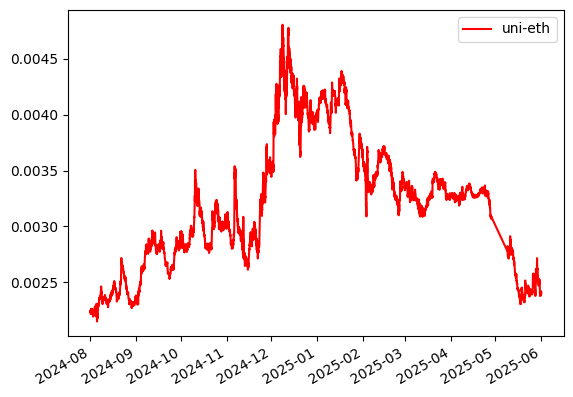

In [4]:
z_score_cutoff                = 6
window_size                   = 24*30

# Data for strategy simulation cleaning
STRATEGY_FREQUENCY                       = 'h'
# Filter according to Median Absolute Deviation (MAD)
# 1. Generate rolling median
simulate_data_filtered                   = ActiveStrategyFramework.aggregate_price_data(uni_pool_data,STRATEGY_FREQUENCY)
simulate_data_filtered_roll              = simulate_data_filtered.quotePrice.rolling(window=window_size)
simulate_data_filtered['roll_median']    = simulate_data_filtered_roll.median()
roll_dev                                 = np.abs(simulate_data_filtered.quotePrice - simulate_data_filtered.roll_median)
# 2. Compute rolling absolute deviation of current price from median under Gaussian
simulate_data_filtered['median_abs_dev'] = 1.4826*roll_dev.rolling(window=window_size).median()
# 3. Identify outliers based on outliers based on MAD 
outlier_indices                          = np.abs(simulate_data_filtered.quotePrice - simulate_data_filtered.roll_median) >= z_score_cutoff*simulate_data_filtered['median_abs_dev']
simulate_data_filtered                   = simulate_data_filtered[~outlier_indices]
# 4. Generate z-scores
simulate_data_filtered['price_return']   = simulate_data_filtered['quotePrice'].pct_change()

%matplotlib inline

price_chart = pd.DataFrame({'uni-eth': simulate_data_filtered['quotePrice']})
price_chart = price_chart.rename_axis(index={'time_pd':'time'})
price_chart.plot(color='red')

## Return

<Axes: >

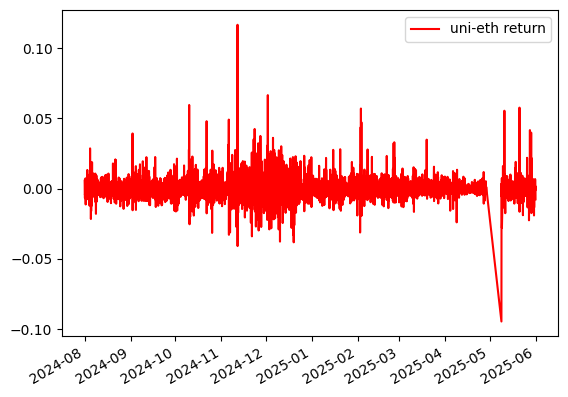

In [5]:
price_chart = pd.DataFrame({'uni-eth return': simulate_data_filtered['price_return']})
price_chart = price_chart.rename_axis(index={'time_pd':'time'})
price_chart.plot(color='red')

# Volatility

<Axes: xlabel='time'>

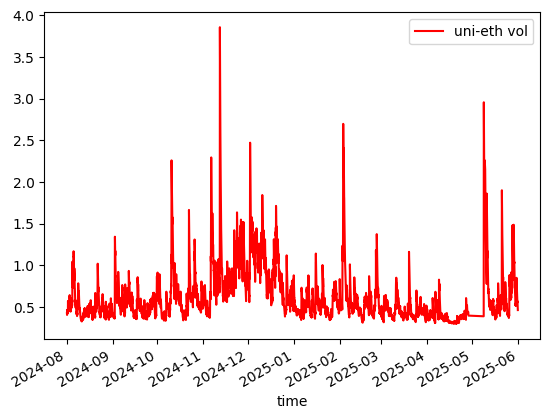

In [6]:
data_filled_clean        = simulate_data_filtered.dropna(axis=0,subset=['price_return']).copy()

ar_model                 = arch.univariate.ARX(data_filled_clean.price_return, lags=1,rescale=True)
ar_model.volatility      = arch.univariate.GARCH(p=1,q=1)      
res                      = ar_model.fit(update_freq=0, disp="off")

volatility_df            = pd.DataFrame({'uni-eth vol': res.conditional_volatility})
volatility_df['time']    = data_filled_clean.index
volatility_df            = volatility_df.set_index("time")
volatility_df.plot(color='red')

# Simulation

After an optimization process that was conducted to calibrate the relevant parameters, let's look at simulated performance from July 1st to September 10 2021.

In [11]:
import importlib
import itertools
import pandas as pd
import numpy as np
importlib.reload(GetPoolData)
importlib.reload(ActiveStrategyFramework)
importlib.reload(AutoRegressiveStrategy)

# Select date range
DATE_BEGIN = pd.to_datetime('2024-12-01 00:00:00', utc=True)
DATE_END = pd.to_datetime('2025-05-31 23:59:59', utc=True)
z_score_cutoff = 5
window_size = 24 * 30  # 720 hours for 30 days

# Debug data sources
print(f"uni_pool_data shape: {uni_pool_data.shape}")
print(f"uni_pool_data timestamp range: {uni_pool_data.index.min()} to {uni_pool_data.index.max()}")
print(f"uni_pool_data index dtype: {uni_pool_data.index.dtype}")
print(f"eth_usdc_pool_data shape: {eth_usdc_pool_data.shape}")
print(f"eth_usdc_pool_data timestamp range: {eth_usdc_pool_data.index.min()} to {eth_usdc_pool_data.index.max()}")
print(f"eth_usdc_pool_data index dtype: {eth_usdc_pool_data.index.dtype}")
print(f"token_0_usd_data shape: {token_0_usd_data.shape}")
print(f"token_0_usd_data timestamp range: {token_0_usd_data.index.min()} to {token_0_usd_data.index.max()}")
print(f"token_0_usd_data index dtype: {token_0_usd_data.index.dtype}")

# Convert indices
uni_pool_data.index = uni_pool_data.index.astype('datetime64[ns, UTC]')
eth_usdc_pool_data.index = eth_usdc_pool_data.index.astype('datetime64[ns, UTC]')
token_0_usd_data.index = token_0_usd_data.index.astype('datetime64[ns, UTC]')
print(f"uni_pool_data index dtype after conversion: {uni_pool_data.index.dtype}")
print(f"eth_usdc_pool_data index dtype after conversion: {eth_usdc_pool_data.index.dtype}")
print(f"token_0_usd_data index dtype after conversion: {token_0_usd_data.index.dtype}")

# Data for simulation
STRATEGY_FREQUENCY = 'h'
uni_pool_data_filtered = uni_pool_data[
    (uni_pool_data.index >= DATE_BEGIN - pd.Timedelta(days=1)) &
    (uni_pool_data.index <= DATE_END)
].copy()
print(f"uni_pool_data_filtered shape: {uni_pool_data_filtered.shape}")
if uni_pool_data_filtered.empty:
    raise ValueError("uni_pool_data_filtered is empty.")

simulate_data_filtered = ActiveStrategyFramework.aggregate_price_data(uni_pool_data_filtered, STRATEGY_FREQUENCY)
print(f"simulate_data_filtered shape: {simulate_data_filtered.shape}")
if simulate_data_filtered.empty:
    raise ValueError("simulate_data_filtered is empty.")

simulate_data_filtered_roll = simulate_data_filtered.quotePrice.rolling(window=window_size)
simulate_data_filtered['roll_median'] = simulate_data_filtered_roll.median()
roll_dev = np.abs(simulate_data_filtered.quotePrice - simulate_data_filtered.roll_median)
simulate_data_filtered['median_abs_dev'] = 1.4826 * roll_dev.rolling(window=window_size).median()
outlier_indices = np.abs(simulate_data_filtered.quotePrice - simulate_data_filtered.roll_median) >= z_score_cutoff * simulate_data_filtered['median_abs_dev']
simulate_data_price = simulate_data_filtered[~outlier_indices]['quotePrice'][DATE_BEGIN:DATE_END]
print(f"simulate_data_price shape: {simulate_data_price.shape}")
if len(simulate_data_price) < 10:
    raise ValueError(f"simulate_data_price too short: {len(simulate_data_price)} rows. Need at least 10.")

# USD Data
token_0_usd_data_filtered = token_0_usd_data[DATE_BEGIN:DATE_END].copy()
print(f"token_0_usd_data_filtered shape: {token_0_usd_data_filtered.shape}")
if token_0_usd_data_filtered.empty:
    raise ValueError("token_0_usd_data_filtered is empty.")

initial_token_0_usd = token_0_usd_data_filtered['quotePrice'].iloc[0]
initial_usd_price = 1 / initial_token_0_usd
INITIAL_TOKEN_0 = 100000 / initial_usd_price
INITIAL_TOKEN_1 = INITIAL_TOKEN_0 * simulate_data_price.iloc[0]
FEE_TIER = 0.003
DECIMALS_0 = 18
DECIMALS_1 = 18

# Strategy Parameters
alpha_range = [1.5, 1.75, 2.0]
tau_range = [0.05, 0.25, 0.5]
vol_range = [0.85]
ret_forecast_range = [0.5]
sim_performance = []
sim_results = []
sim_data_collect = []

# Single thread
for j in list(itertools.product(alpha_range, tau_range, vol_range, ret_forecast_range)):
    print(j)
    AR_Strategy = AutoRegressiveStrategy.AutoRegressiveStrategy(
        uni_pool_data, j[0], j[1], j[2], data_frequency='h', return_forecast_cutoff=j[3], z_score_cutoff=5
    )
    simulated_strategy = ActiveStrategyFramework.simulate_strategy(
        simulate_data_price, uni_pool_data, AR_Strategy, INITIAL_TOKEN_0, INITIAL_TOKEN_1, FEE_TIER, DECIMALS_0, DECIMALS_1
    )
    sim_data = ActiveStrategyFramework.generate_simulation_series(
        simulated_strategy, AR_Strategy, token_0_usd_data=token_0_usd_data_filtered
    )
    strat_result = ActiveStrategyFramework.analyze_strategy(sim_data, frequency=STRATEGY_FREQUENCY)
    strat_result['alpha_param'] = j[0]
    strat_result['tau_param'] = j[1]
    strat_result['volatility_param'] = j[2]
    sim_results.append(simulated_strategy)
    sim_performance.append(strat_result)
    sim_data_collect.append(sim_data)

uni_pool_data shape: (76684, 22)
uni_pool_data timestamp range: 2024-06-01 00:00:35+00:00 to 2025-01-31 23:32:47+00:00
uni_pool_data index dtype: datetime64[ns, UTC]
eth_usdc_pool_data shape: (91285, 22)
eth_usdc_pool_data timestamp range: 2024-06-01 00:26:59+00:00 to 2025-01-31 23:59:59+00:00
eth_usdc_pool_data index dtype: datetime64[ns, UTC]
token_0_usd_data shape: (437747, 24)
token_0_usd_data timestamp range: 2024-08-01 00:08:00+00:00 to 2025-05-31 23:54:00+00:00
token_0_usd_data index dtype: datetime64[ns, UTC]
uni_pool_data index dtype after conversion: datetime64[ns, UTC]
eth_usdc_pool_data index dtype after conversion: datetime64[ns, UTC]
token_0_usd_data index dtype after conversion: datetime64[ns, UTC]
uni_pool_data_filtered shape: (28831, 22)
Input data index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Input data index dtype: datetime64[ns, UTC]
data_floored_min index dtype after conversion: datetime64[ns, UTC]
data_floored_min index type after floor: <class

ValueError: Insufficient data for AR model: 0 samples available, need at least 10.

In [89]:
pd.DataFrame(sim_performance)

,days_strategy,gross_fee_apr,gross_fee_return,net_apr,net_return,rebalances,compounds,max_drawdown,volatility,sharpe_ratio,impermanent_loss,mean_base_position,median_base_position,mean_base_width,median_base_width,final_value,alpha_param,tau_param,volatility_param
0,124,0.056274,0.019118,-1.057404,-0.359228,67,0,0.602280,1.118304,-0.945543,-0.010326,0.798107,0.742850,1.836694,1.831813,128154.437364,1.50,0.05,0.85
1,124,0.059965,0.020372,-1.101841,-0.374324,9,0,0.602651,1.082952,-1.017442,-0.033642,0.674333,0.668983,1.688709,1.736222,125135.208421,1.50,0.25,0.85
2,124,0.072334,0.024574,-1.130058,-0.383910,4,0,0.603891,1.078182,-1.048114,-0.048448,0.635500,0.666622,1.679517,1.766110,123217.978332,1.50,0.50,0.85
3,124,0.048541,0.016491,-1.055667,-0.358638,55,0,0.602835,1.119606,-0.942892,-0.009415,0.788181,0.743076,2.063534,2.068403,128272.461564,1.75,0.05,0.85
4,124,0.047930,0.016283,-1.088890,-0.369924,8,0,0.602910,1.094188,-0.995159,-0.026847,0.695166,0.697381,1.989668,2.088049,126015.139110,1.75,0.25,0.85
5,124,0.060935,0.020701,-1.105440,-0.375547,5,0,0.602769,1.090959,-1.013274,-0.035531,0.660774,0.661960,1.955747,2.065160,124890.651186,1.75,0.50,0.85
6,124,0.045376,0.015416,-1.029803,-0.349851,44,0,0.597712,1.117004,-0.921933,0.004156,0.792060,0.742900,2.233321,2.203753,130029.821362,2.00,0.05,0.85
7,124,0.045699,0.015525,-1.061040,-0.360463,8,0,0.598285,1.099834,-0.964728,-0.012234,0.694576,0.672859,2.128353,2.202774,127907.388615,2.00,0.25,0.85
8,124,0.028823,0.009792,-1.108766,-0.376677,3,0,0.603829,1.092494,-1.014894,-0.037276,0.699555,0.703104,2.053292,2.035395,124664.699531,2.00,0.50,0.85


We can do a bit better, let's run a simple optimizer that is trying to minimize the impermanent loss of the strategy.

In [ ]:
########################################
# Optimizer code
########################################

from scipy import optimize
def run_hypervisor_single(j):
    AR_Strategy                      = AutoRegressiveStrategy.AutoRegressiveStrategy(uni_pool_data,j[0],j[1],j[2],data_frequency=STAT_MODEL_FREQUENCY,return_forecast_cutoff=.5,z_score_cutoff=5)
    simulated_strategy               = ActiveStrategyFramework.simulate_strategy(simulate_data_price,uni_pool_data,AR_Strategy,INITIAL_TOKEN_0,INITIAL_TOKEN_1,FEE_TIER,DECIMALS_0,DECIMALS_1)
    sim_data                         = ActiveStrategyFramework.generate_simulation_series(simulated_strategy,AR_Strategy,token_0_usd_data=token_0_usd_data_filtered)
    strat_result                     = ActiveStrategyFramework.analyze_strategy(sim_data,frequency=STRATEGY_FREQUENCY)
    print('Guess {}: || IL: {}'.format(j,strat_result['impermanent_loss']))
    return -strat_result['impermanent_loss']

o1 = optimize.minimize(fun=run_hypervisor_single, x0=np.array([2.25,.025,.85]),method='COBYLA')

In [92]:
AR_Strategy                      = AutoRegressiveStrategy.AutoRegressiveStrategy(uni_pool_data,o1.x[0],o1.x[1],o1.x[2],data_frequency=STAT_MODEL_FREQUENCY,return_forecast_cutoff=.5,z_score_cutoff=5)
simulated_strategy               = ActiveStrategyFramework.simulate_strategy(simulate_data_price,uni_pool_data,AR_Strategy,INITIAL_TOKEN_0,INITIAL_TOKEN_1,FEE_TIER,DECIMALS_0,DECIMALS_1)
sim_data                         = ActiveStrategyFramework.generate_simulation_series(simulated_strategy,AR_Strategy,token_0_usd_data=token_0_usd_data_filtered)
strat_result                     = ActiveStrategyFramework.analyze_strategy(sim_data,frequency=STRATEGY_FREQUENCY)
print(strat_result)

/home/gcamilo/.local/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


{'days_strategy': 124, 'gross_fee_apr': 0.04315072529431781, 'gross_fee_return': 0.014659424483549064, 'net_apr': -1.0067970189169784, 'net_return': -0.3420351516320693, 'rebalances': 124, 'compounds': 0, 'max_drawdown': 0.5943525399218711, 'volatility': 1.1223535547204793, 'sharpe_ratio': -0.8970408786808003, 'impermanent_loss': 0.01622769141961438, 'mean_base_position': 0.830485808911782, 'median_base_position': 0.8054164759563147, 'mean_base_width': 2.4639437167386635, 'median_base_width': 2.4242247482453685, 'final_value': 131592.96967358614}


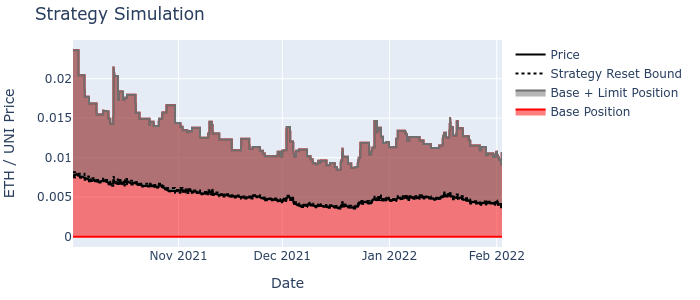

In [93]:
resulting_data     = sim_data
p = ActiveStrategyFramework.plot_strategy(resulting_data,'ETH / UNI Price')

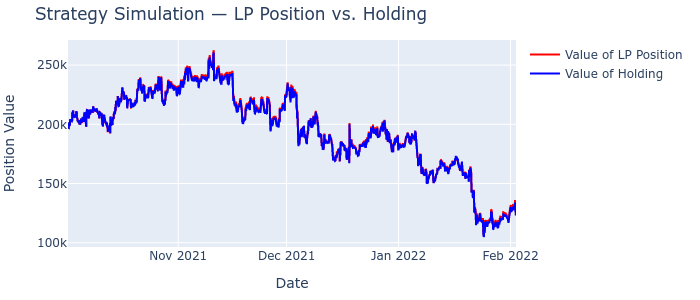

In [94]:
p = ActiveStrategyFramework.plot_position_value(resulting_data)

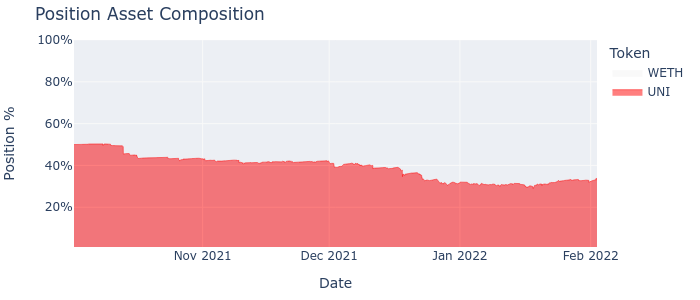

In [95]:
p = ActiveStrategyFramework.plot_asset_composition(resulting_data,'UNI','WETH')

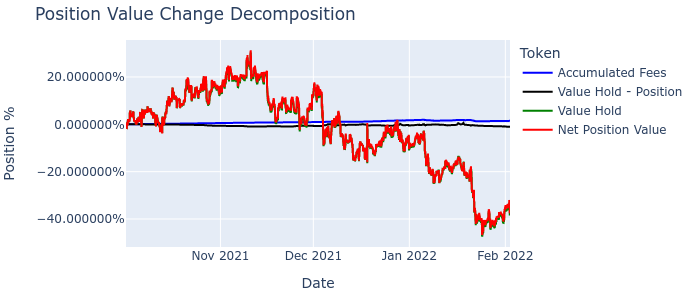

In [96]:
p = ActiveStrategyFramework.plot_position_return_decomposition(resulting_data)

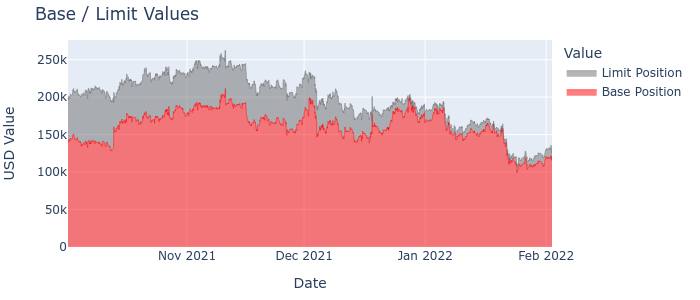

In [97]:
p = ActiveStrategyFramework.plot_position_composition(resulting_data)